In [1]:
import numpy as np
from osgeo import gdal
from osgeo import osr

def get_file_info(in_file_path):
    """ only support tif file. return: gdal dataset, spatial coordinate system,
    projection coordinate system and file size.
    """
    pcs = None
    gcs = None
    shape = None

    #
    if in_file_path.endswith('.tif') or in_file_path.endswith('.TIF'):
        dataset = gdal.Open(in_file_path)
        pcs = osr.SpatialReference()
        pcs.ImportFromWkt(dataset.GetProjection())
        #
        gcs = pcs.CloneGeogCS()
        #
        extend = dataset.GetGeoTransform()
        #
        shape = (dataset.RasterXSize, dataset.RasterYSize)
    else:
        raise("Unsupport file!")
    return dataset, gcs, pcs, extend, shape

def lonlat_to_xy():
    ''' return projected x and y'''
    ct = osr.CoordinateTransfotmation(gcs, pcs)
    coordinates = ct.TransformPoint(lon, lat)
    return coordinates[0], coordinates[1], coordinates[2]

def xy_to_lonlat(gcs, pcs, x, y):
    '''
    投影坐标--》经纬度坐标。 xy 为相元行列号。return 投影坐标对应的地理空间坐标
    '''
    ct = osr.CoordinateTransformation(pcs, gcs)
    lon, lat, _ = ct.TransformPoint(x, y)
    return lon, lat

def xy_to_rowcol(extend, x, y):
    '''
    extend 图像空间范围；
    x:投影坐标x
    y:投影坐标y
    return (x, y) to (row, col)
    
    '''
    a = np.array([[extend[1], extend[2]], [extend[4], extend[5]]])
    b = np.array([x - extend[0], y - extend[3]])
    row_col = np.linalg.solve(a, b)#二元一次求解
    row = int(np.floor(row_col[1]))
    col = int(np.floor(row_col[0]))
    return row, col
def rowcol_to_xy(extend, row, col):
    '''
    extend 图像空间范围；
    return (x, y) to (row, col) 行列号对应的投影坐标 
    '''
    x = extend[0] + row * extend[1] + col * extend[2] 
    y = extend[3] + row * extend[4] + col * extend[5]
    return x, y
def get_value_by_coordinates(file_path, coordinates, coordinate_type = "rowcol"):
                                    
    '''coordinate_type: "rowcol", "xy", "lonlat"
    return 指定坐标相元值'''

    #
    dataset, gcs, pcs, extend, shape = get_file_info(file_path)
    img = dataset.GetRasterBand(1).ReadAsArray()
    value = None
    #
    if coordinate_type == "rowcol":
        value = img[coordinates[0], coordinates[1]]
    elif   coordinate_type == "lonlat":
        x, y, _ = lonlat_to_xy(gcs, pcs, coordinates[0], coordinates[1])
        row, col = xy_to_rowcol(extend, x, y)
        value = img[row, col]
    elif   coordinate_type == "xy":
        row, col = xy_to_rowcol(extend, coordinates[0], coordinates[1])
        value = img[row, col]
    else:
        raise('coordinate_type may be wrong!')
    return value
                   

In [47]:
path = r'G:\china_geodata\yunnan_region\chang\dem_WGS84.tif'
_, gcs, pcs, extend, _ = get_file_info(path)

In [48]:
pcs

<osgeo.osr.SpatialReference; proxy of <Swig Object of type 'OSRSpatialReferenceShadow *' at 0x000001DD15E83EA0> >

In [49]:
def writeTiff(im_data,im_width,im_height,im_bands,im_geotrans,im_proj,path):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32

    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    elif len(im_data.shape) == 2:
        im_data = np.array([im_data])
    else:
        im_bands, (im_height, im_width) = 1,im_data.shape
        #创建文件
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, im_width, im_height, im_bands, datatype)
    if(dataset!= None):
        dataset.SetGeoTransform(im_geotrans) #写入仿射变换参数
        dataset.SetProjection(im_proj) #写入投影
    for i in range(im_bands):
        dataset.GetRasterBand(i+1).WriteArray(im_data[i])
    del dataset

In [50]:
ds = gdal.Open(path)
tr = ds.GetGeoTransform()
prj = ds.GetProjection()
x1 = ds.RasterXSize
y1 = ds.RasterYSize
im_bands = ds.RasterCount #波段数
lon = []
lat = []
for i in range(x1):
    for j in range(y1):
        #a, b = rowcol_to_xy(extend, i, j)
        a, b = xy_to_lonlat(gcs, pcs, i, j)
        lon.append(a)
        lat.append(b)

In [45]:
rowcol_to_xy(extend, 500, 500)

(-810667.1822406978, 3012635.475413719)

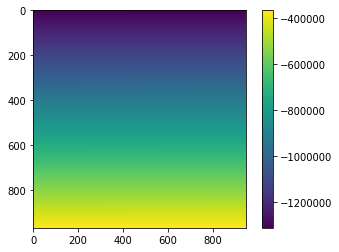

In [41]:
import matplotlib.pyplot as plt

lon = np.array(lon).reshape(y1, x1)
lat = np.array(lat).reshape(y1, x1)
plt.imshow(lon)
plt.colorbar()

In [52]:
writeTiff(lon,x1,y1,im_bands,tr,prj,r'G:\china_geodata\yunnan_region\lon.tif')

AttributeError: 'list' object has no attribute 'dtype'

In [46]:
#writeTiff(lat,x1,y1,im_bands,tr,prj,r'G:\china_geodata\yunnan_region\lat.tif')

In [51]:
1/111

0.009009009009009009